In [1]:
try:
    GUTENBERG = True
    from gutenberg.acquire import load_etext
    from gutenberg.query import get_etexts, get_metadata
    from gutenberg.acquire import get_metadata_cache
    from gutenberg.acquire.text import UnknownDownloadUriException
    from gutenberg.cleanup import strip_headers
    from gutenberg._domain_model.exceptions import CacheAlreadyExistsException
except ImportError:
    GUTENBERG = False
    print('Gutenberg is not installed. See instructions at https://pypi.python.org/pypi/Gutenberg')
from keras.models import Input, Model
from keras.layers import Dense, Dropout
from keras.layers import LSTM
from keras.layers.wrappers import TimeDistributed
import keras.callbacks
import keras.backend as K
import scipy.misc
import json

import os, sys
import re
import PIL
from PIL import ImageDraw

from keras.optimizers import RMSprop
import random
import numpy as np
import tensorflow as tf
from keras.utils import get_file

from IPython.display import clear_output, Image, display, HTML
try:
    from io import BytesIO
except ImportError:
    from StringIO import StringIO as BytesIO

Using TensorFlow backend.


In [2]:
if GUTENBERG:
    cache = get_metadata_cache()
    try:
        cache.populate()
    except CacheAlreadyExistsException:
        pass

In [3]:
if GUTENBERG:
    for text_id in get_etexts('author', 'Shakespeare, William'):
        pass#print(text_id, list(get_metadata('title', text_id))[0])

In [4]:
GUTENBERG = False

In [7]:
import os

TXT_FILE = os.path.join('data', 'hitch_hiker.txt')

In [9]:
if GUTENBERG:
    shakespeare = strip_headers(load_etext(100))
else:
    path = TXT_FILE
    hitch_hiker = open(path).read()
training_text = hitch_hiker
len(training_text)

279056

In [11]:
#print(training_text)

In [16]:
import json
import nltk
from nltk.metrics import association

# Load in human language data from wherever you've saved it
data = hitch_hiker

# Number of collocations to find

N = 25

all_tokens = hitch_hiker.split()
#print(all_tokens)
finder = nltk.BigramCollocationFinder.from_words(all_tokens)
finder.apply_freq_filter(2)
finder.apply_word_filter(lambda w: w in nltk.corpus.stopwords.words('english'))
scorer = association.BigramAssocMeasures.jaccard
collocations = finder.nbest(scorer, N)

for collocation in collocations:
    c = ' '.join(collocation)
    print(c)

"Sure thing,"
Antarean parakeet
Bugblatter Beast
Crested Eagle
Frond Crested
Hitch Hiker's
Hyperlobic Omni-Cognate
Marvin," lilted
Mostly Harmless.
Omni-Cognate Neutron
Ravenous Bugblatter
Ursa Minor
callous heartless
carbon monoxide.
coughed politely.
heartless exterior
hydrogen, ozone
marketing division
orange sash
outlying regions
respectable physicists
underlying metaphor
Sirius Cybernetics
Cybernetics Corporation
Hiker's Guide


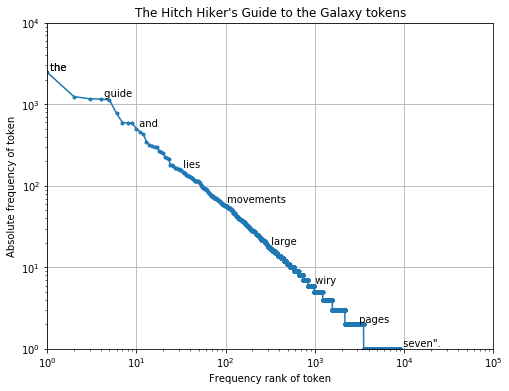

In [18]:
from __future__ import division
from itertools import *
from pylab import *
from nltk.corpus import brown
from collections import Counter
from string import *

def lower(text):
    return text.lower()

# The data: token counts from The Hitch Hiker's Guide to the Galaxy
tokens_with_count = Counter(map(lower, all_tokens))
counts = array(list(tokens_with_count.values()))
tokens = list(tokens_with_count.keys())

# A Zipf plot
ranks = arange(1, len(counts)+1)
indices = argsort(-counts)
frequencies = counts[indices]
plt.figure(figsize=(8,6))
plt.ylim(1,10**4)
plt.xlim(1,10**5)
loglog(ranks, frequencies, marker=".")
title("The Hitch Hiker's Guide to the Galaxy tokens")
xlabel("Frequency rank of token")
ylabel("Absolute frequency of token")
grid(True)
for n in list(logspace(-0.5, log10(len(counts)), 10).astype(int)):
    dummy = text(ranks[n], frequencies[n], " " + tokens[n], 
                 verticalalignment="bottom",
                 horizontalalignment="left")

show()

In [19]:
chars = list(sorted(set(training_text)))
char_to_idx = {ch: idx for idx, ch in enumerate(chars)}
len(chars)

83

In [20]:
def char_rnn_model(num_chars, num_layers, num_nodes=512, dropout=0.1):
    input = Input(shape=(None, num_chars), name='input')
    prev = input
    for i in range(num_layers):
        lstm = LSTM(num_nodes, return_sequences=True, name='lstm_layer_%d' % (i + 1))(prev)
        if dropout:
            prev = Dropout(dropout)(lstm)
        else:
            prev = lstm
    dense = TimeDistributed(Dense(num_chars, name='dense', activation='softmax'))(prev)
    model = Model(inputs=[input], outputs=[dense])
    model.compile(loss='categorical_crossentropy', optimizer='nadam', metrics=['acc'])
    return model

In [29]:
model = char_rnn_model(len(chars), num_layers=2, num_nodes=420, dropout=0.2)
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           (None, None, 83)          0         
_________________________________________________________________
lstm_layer_1 (LSTM)          (None, None, 420)         846720    
_________________________________________________________________
dropout_6 (Dropout)          (None, None, 420)         0         
_________________________________________________________________
lstm_layer_2 (LSTM)          (None, None, 420)         1412880   
_________________________________________________________________
dropout_7 (Dropout)          (None, None, 420)         0         
_________________________________________________________________
time_distributed_3 (TimeDist (None, None, 83)          34943     
Total params: 2,294,543
Trainable params: 2,294,543
Non-trainable params: 0
_________________________________________________________________


In [31]:
CHUNK_SIZE = 30

def data_generator(all_text, char_to_idx, batch_size, chunk_size):
    X = np.zeros((batch_size, chunk_size, len(char_to_idx)))
    y = np.zeros((batch_size, chunk_size, len(char_to_idx)))
    while True:
        for row in range(batch_size):
            idx = random.randrange(len(all_text) - chunk_size - 1)
            chunk = np.zeros((chunk_size + 1, len(char_to_idx)))
            for i in range(chunk_size + 1):
                chunk[i, char_to_idx[all_text[idx + i]]] = 1
            X[row, :, :] = chunk[:chunk_size]
            y[row, :, :] = chunk[1:]
        yield X, y

#next(data_generator(training_text, char_to_idx, 4, chunk_size=CHUNK_SIZE))

In [ ]:
early = keras.callbacks.EarlyStopping(monitor='loss',
                              min_delta=0.02,
                              patience=4,
                              verbose=0, mode='auto')

BATCH_SIZE = 300
model.fit_generator(
    data_generator(training_text, char_to_idx, batch_size=BATCH_SIZE, chunk_size=CHUNK_SIZE),
    epochs=40,
    callbacks=[early,],
    steps_per_epoch=2 * len(training_text) / (BATCH_SIZE * CHUNK_SIZE),
    verbose=1
)

Epoch 1/40
63/62 [==============================] - 33s 530ms/step - loss: 3.2621 - acc: 0.1727
Epoch 2/40
 7/62 [==>...........................] - ETA: 21s - loss: 3.0506 - acc: 0.1912

In [384]:
def generate_output(model, training_text, start_index=None, diversity=0.5, amount=400):
    if start_index is None:
        start_index = random.randint(0, len(training_text) - CHUNK_SIZE - 1)
    generated = training_text[start_index: start_index + CHUNK_SIZE]
    yield generated + '#'
    for i in range(amount):
        x = np.zeros((1, len(generated), len(chars)))
        for t, char in enumerate(generated):
            x[0, t, char_to_idx[char]] = 1.
        preds = model.predict(x, verbose=0)[0]
        if diversity is None:
            next_index = np.argmax(preds[len(generated) - 1])
        else:
            preds = np.asarray(preds[len(generated) - 1]).astype('float64')
            preds = np.log(preds) / diversity
            exp_preds = np.exp(preds)
            preds = exp_preds / np.sum(exp_preds)
            probas = np.random.multinomial(1, preds, 1)
            next_index = np.argmax(probas)     
        next_char = chars[next_index]
        yield next_char

        generated += next_char
    return generated

for ch in generate_output(model, training_text):
    sys.stdout.write(ch)
print()

appened to  my  mind,  I
did  it.  And I# dided to light a good noise.

He said, "There's a sort of paralons and the land stemped out of the  space  of  the
Universe for the sevention that they were fasted in his own o consere, and  then  the
Galaxy as if it was the aircar flung  in  the  President  of  the  Galaxy
seat  the  galaxy  and  all  the
major  clinking  and  computers  with  the  make  sea  and  ma  commanded   passing  on  hi
